In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import seaborn as sns


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [2]:

print("Downloading MSFT data...")
data = yf.download("MSFT", start='2020-01-01')
data = data.copy()
data.loc[:, "LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))
data.dropna()




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,LogReturn
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,
Date,,,,,,
2020-01-03,151.414108,152.683690,150.879551,151.127749,21116200,-0.012530
2020-01-06,151.805481,151.872308,149.399957,149.944070,20813700,0.002581
2020-01-07,150.421356,152.416407,150.173173,152.082316,21634100,-0.009160
2020-01-08,152.817352,153.495104,150.774570,151.710046,27746500,0.015803
2020-01-09,154.726456,154.850555,153.714612,154.487813,21385000,0.012415
...,...,...,...,...,...,...
2025-03-31,375.390015,377.070007,367.239990,372.540009,35184700,-0.009043
2025-04-01,382.190002,382.850006,373.230011,374.649994,19689500,0.017952


In [3]:
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm

# === Parameters ===
window_size = 126
n_clusters = 3
returns = data["LogReturn"].values
windows = [returns[i:i+window_size] for i in range(len(returns) - window_size)]

# === Compute Wasserstein distance matrix (with trend augmentation) ===
n = len(windows)
dist_matrix = np.zeros((n, n))

for i in tqdm(range(n), desc="Computing Wasserstein distances"):
    for j in range(i, n):
        if len(windows[i]) == 0 or len(windows[j]) == 0:
            dist_matrix[i, j] = np.inf
        else:
            try:
                base_dist = wasserstein_distance(windows[i], windows[j])
                trend_diff = np.abs(np.sum(windows[i]) - np.sum(windows[j])) * 0.3
                dist = base_dist + trend_diff
                dist_matrix[i, j] = dist if not np.isnan(dist) else np.inf
            except:
                dist_matrix[i, j] = np.inf
        dist_matrix[j, i] = dist_matrix[i, j]

max_finite = np.max(dist_matrix[np.isfinite(dist_matrix)], initial=1.0)
dist_matrix[~np.isfinite(dist_matrix)] = 10 * max_finite
dist_matrix = dist_matrix / np.max(dist_matrix)

# === KMeans Clustering ===
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dist_matrix)
regimes = kmeans.labels_

# === Label Clusters Based on Return and Volatility ===
cluster_stats = []
for i in range(n_clusters):
    cluster_returns = [windows[j] for j in range(len(windows)) if regimes[j] == i]
    cumulative_return = np.mean([np.sum(r) for r in cluster_returns])
    mean_vol = np.mean([np.std(r) for r in cluster_returns])
    cluster_stats.append((cumulative_return, mean_vol))

sorted_clusters = np.argsort([stat[0] for stat in cluster_stats])[::-1]

regime_labels = np.array(["Sideways"] * len(regimes))
regime_labels[regimes == sorted_clusters[0]] = "Bull"
regime_labels[regimes == sorted_clusters[-1]] = "Bear"

# === Post-processing: Re-label based on thresholds ===
for i in range(len(regime_labels)):
    total_return = np.sum(windows[i])
    if total_return > 0.15:
        regime_labels[i] = "Bull"
    elif total_return < -0.15:
        regime_labels[i] = "Bear"
    elif -0.05 <= total_return <= 0.05:
        regime_labels[i] = "Sideways"

# === Output ===
# regime_labels -> array of "Bull", "Bear", "Sideways"
# windows -> list of return windows used
# dist_matrix -> normalized Wasserstein distance matrix


Computing Wasserstein distances: 100%|██████████| 1196/1196 [00:18<00:00, 63.71it/s] 


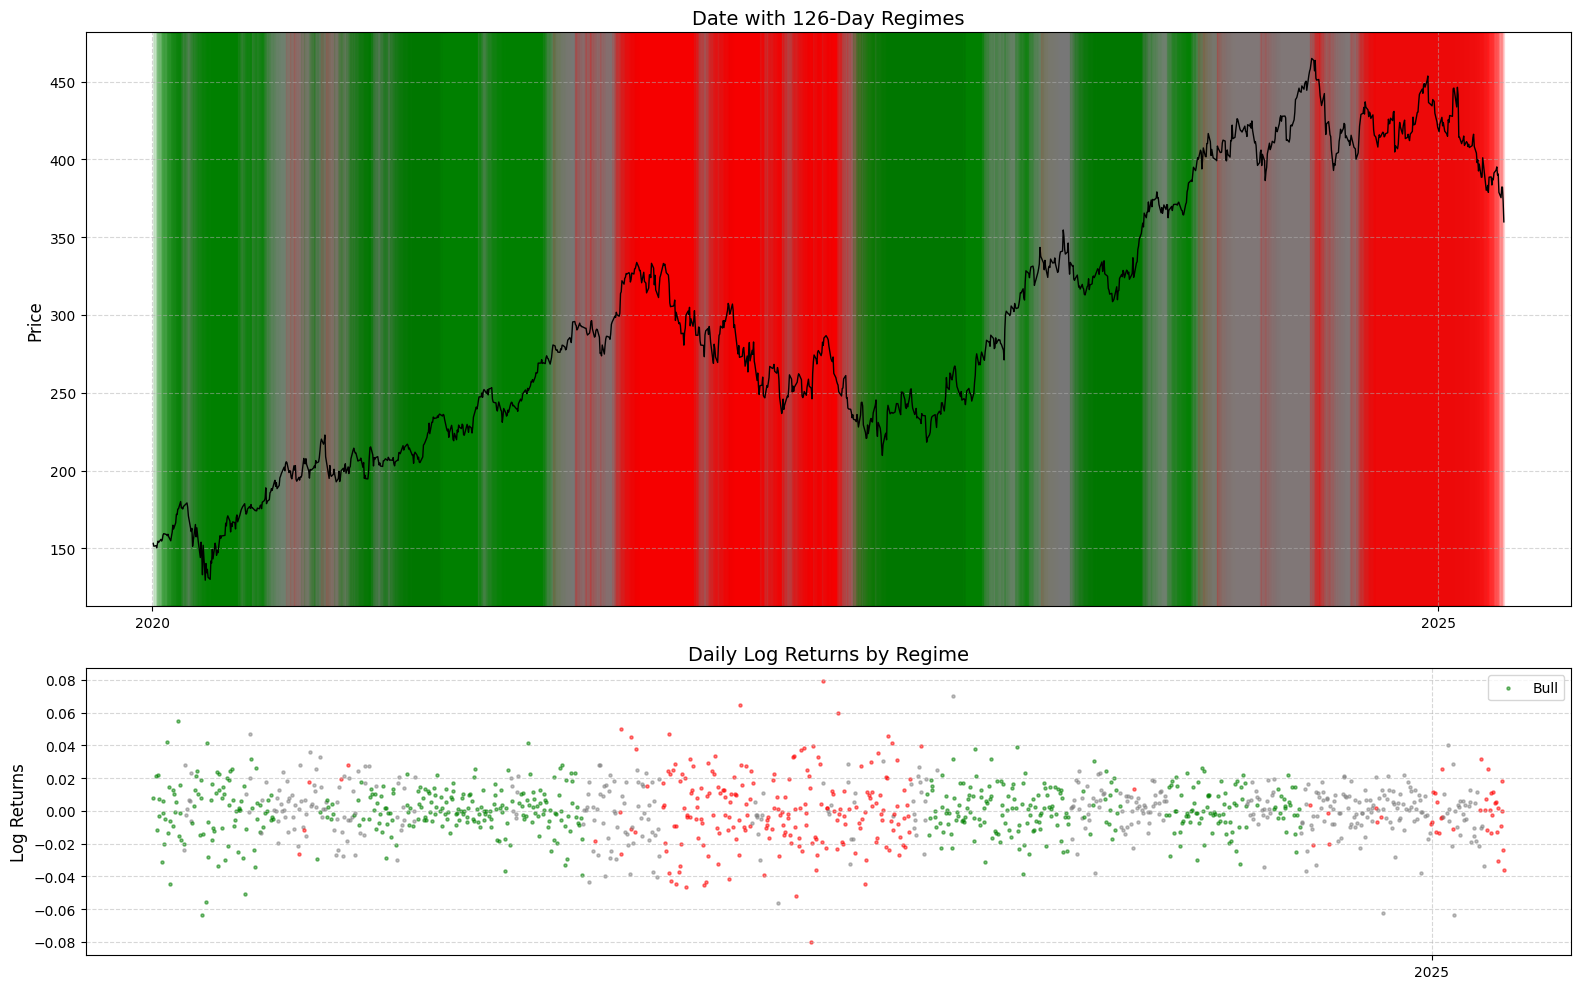

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Extract values ===
dates = data.index.to_numpy()
price = data["Close"].values
log_returns = data["LogReturn"].values

# === Create subplots ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})

# === Regime colors ===
colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}

# === Plot 1: Price with regime shading ===
ax1.plot(dates, price, color='black', lw=1)

for i, label in enumerate(regime_labels):
    start = dates[i]
    end = dates[i + window_size]
    ax1.axvspan(start, end, color=colors[label], alpha=0.1)

ax1.set_title(f"{data.index.name} with {window_size}-Day Regimes", fontsize=14)
ax1.set_ylabel("Price", fontsize=12)

# === Plot 2: Log returns with regime-colored points ===
for i, label in enumerate(regime_labels):
    start = i + window_size
    end = start + 1 if i < len(regime_labels) - 1 else len(data)
    ax2.scatter(dates[start:end], log_returns[start:end],
                color=colors[label], s=5, alpha=0.5, label=label if i == 0 else "")

ax2.set_title("Daily Log Returns by Regime", fontsize=14)
ax2.set_ylabel("Log Returns", fontsize=12)

# === Format x-axis ===
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.grid(True, linestyle='--', alpha=0.5)

# === Legend and Save ===
ax2.legend()
plt.tight_layout()
plt.savefig(f'regimes_{window_size}days.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# === Assign real label to first 126 days based on similarity to clusters ===
# Compute metrics for first 126 days
initial_returns = returns[:window_size]
initial_return_sum = np.sum(initial_returns)
initial_vol = np.std(initial_returns)

# Compute similarity with each cluster's return/vol stats
similarity = []
for cum_ret, vol in cluster_stats:
    dist = np.sqrt((initial_return_sum - cum_ret)**2 + (initial_vol - vol)**2)
    similarity.append(dist)

# Pick the closest matching cluster
closest_cluster_idx = np.argmin(similarity)

# Get the actual label of that cluster (Bull/Bear/Sideways)
sorted_clusters = np.argsort([stat[0] for stat in cluster_stats])[::-1]
regime_ordered_labels = np.array(["Sideways"] * n_clusters)
regime_ordered_labels[sorted_clusters[0]] = "Bull"
regime_ordered_labels[sorted_clusters[-1]] = "Bear"
# The rest remain Sideways
initial_label = regime_ordered_labels[closest_cluster_idx]

# === Now assign full regime labels ===
regime_full = np.array([initial_label] * window_size)  # Assign first 126
regime_full = np.append(regime_full, regime_labels)  


data["Regime"] = regime_full
data[["Close", "Regime"]].to_csv("Results/Regimes.csv")



In [6]:
import pandas as pd

# Load the CSV (date is index)
Regimes_csv = pd.read_csv("Results/Regimes.csv", index_col=0)

# Ensure 'Regime' column exists
if "Regime" not in data.columns:
    raise ValueError("Column 'Regime' not found in ABC.csv")

# Replace any unmapped/undefined values with 'Sideways'
Regimes_csv["Regime"] = Regimes_csv["Regime"].fillna("Sideways")
Regimes_csv["Regime"] = Regimes_csv["Regime"].replace("Undefined", "Sideways")

# Map regime to integer and safely convert to int
regime_mapping = {"Sideways": 0, "Bull": 1, "Bear": -1}
Regimes_csv["Regime"] = Regimes_csv["Regime"].map(regime_mapping)

# Now safely convert to int (no NaNs remain)
Regimes_csv["Regime"] = Regimes_csv["Regime"].astype(int)

# Save to file
Regimes_csv[["Close", "Regime"]].to_csv("Results/Regime_for_Ensemble.csv", index=True)

print("✅ Saved Regime_for_Ensemble.csv with integer codes.")


✅ Saved Regime_for_Ensemble.csv with integer codes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import yfinance as yf

# Step 1: Load clustered regime output
regime_df = pd.read_csv("Results/Regimes.csv", index_col=0, parse_dates=True)
regime_df = regime_df[["Close", "Regime"]].copy()

# Step 2: Map regimes to codes and drop NaNs
regime_mapping = {"Sideways": 0, "Bull": 1, "Bear": -1}
regime_df["Regime"] = regime_df["Regime"].map(regime_mapping)

# Step 3: Download MSFT data and align
price_df = yf.download("MSFT", period="5y", interval="1d")[["Close"]]
price_df["EMA_50"] = price_df["Close"].ewm(span=50, adjust=False).mean()
price_df["LogReturn"] = np.log(price_df["Close"] / price_df["Close"].shift(1))


price_df['Regime'] = regime_df['Regime']
# Step 5: Train-test split
features = ["Close", "LogReturn", "EMA_50"]
target = "Regime"

train = price_df.iloc[:-504]
test = price_df.iloc[-504:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Ste

KeyboardInterrupt: 